In [1]:
import torch
import triton
import triton.language as tl
from copy import deepcopy
import os
os.environ['TRITON_PRINT_AUTOTUNING'] = '1'
from fp8_kernel import act_quant_block, Fp8Linear, weight_quant_block, fp8_matmul_wo_quant
# deepseekv3 官方kernel
from offical_kernel import act_quant
import os
try:
    import transformer_engine.pytorch as te
    from transformer_engine.common import recipe
    HAVE_TE = True
except:
    HAVE_TE = False
    print('transformer engine is not installed')
print(triton.__version__)


[WARNING  | root               ]: Supported flash-attn versions are >= 2.1.1, <= 2.6.3. Found flash-attn 2.7.4.post1.


3.2.0


- 以下测试均使用H800
- A100系列显卡，硬件不支持fp8，只有软件支持，无法跑出下面的结果
- triton请务必使用3.2.0，3.1.0也跑不出下面的结果

# 激活值量化
- 对activation按块进行量化，比官方的会快些

In [2]:
dtype = torch.bfloat16
# A100系列用e5m2
fp8_dtype = torch.float8_e4m3fn
device = 'cuda'
bias = False
bs, seq_len, d = 8, 4096, 4096
x = torch.randn(bs, seq_len, d, dtype=dtype, device=device)
y1, s1 = act_quant(x)
y2, s2 = act_quant_block(x, dtype=fp8_dtype)
print(torch.allclose(y1.to(torch.float32), y2.to(torch.float32)))
print(torch.allclose(s1.to(torch.float32), s2.to(torch.float32)))

True
True


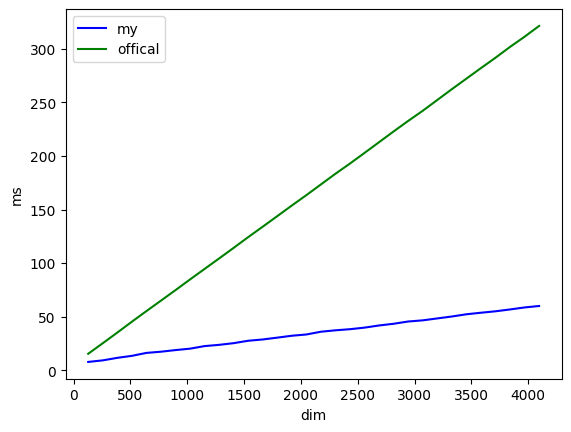

fp8 quant:
       dim         my     offical
0    128.0   7.747984   15.359689
1    256.0   9.187445   25.183005
2    384.0  11.552305   35.129812
3    512.0  13.409155   45.260500
4    640.0  16.161809   55.177853
5    768.0  17.287217   64.951800
6    896.0  18.798193   74.753605
7   1024.0  20.123187   84.748372
8   1152.0  22.525398   94.552226
9   1280.0  23.690591  104.337350
10  1408.0  25.260704  114.236459
11  1536.0  27.511584  124.267057
12  1664.0  28.716566  134.008661
13  1792.0  30.420434  143.872276
14  1920.0  32.194570  153.782949
15  2048.0  33.361338  163.462862
16  2176.0  35.943750  173.471242
17  2304.0  37.263945  183.442831
18  2432.0  38.309503  192.978188
19  2560.0  39.773703  202.909410
20  2688.0  41.787986  212.941095
21  2816.0  43.379698  222.958356
22  2944.0  45.486253  232.774854
23  3072.0  46.562269  242.219046
24  3200.0  48.360914  252.303809
25  3328.0  50.147306  262.381494
26  3456.0  52.226957  272.212267
27  3584.0  53.674541  282.057106
28 

In [3]:
torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['dim'],  # argument names to use as an x-axis for the plot
        x_vals=[128 * i for i in range(1, 32+1, 1)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['my', 'offical'],  # possible values for `line_arg``
        line_names=[
            "my",
            "offical",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="fp8 quant",  # name for the plot. Used also as a file name for saving the plot.
        args={'bs': 4, 'seq_len': 4096}
    ))
def benchmark(bs, seq_len, dim, provider):
    device = torch.device('cuda')
    dtype = torch.bfloat16
    device = 'cuda'
    x = torch.randn(bs, seq_len, dim).to(device).to(dtype)
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    if provider == 'my':
        ms = triton.testing.do_bench(lambda: act_quant_block(x))
    if provider == 'offical':
        ms = triton.testing.do_bench(lambda: act_quant(x))
    return ms * 1e3
benchmark.run(show_plots=True, print_data=True)

# fp8矩阵乘法
- deepseek v3的fp模式 vs torch bf16的精度

In [4]:
dtype = torch.bfloat16
fp8_dtype = torch.float8_e4m3fn
device = 'cuda'
bias = True
bs, seq_len, d = 4,4096, 4096
x1 = torch.randn(bs, seq_len, d, dtype=dtype, device=device)
x1.requires_grad_(True)
x2 = deepcopy(x1)
fc1 = torch.nn.Linear(d, d, bias=bias, device=device, dtype=dtype)
fc2 = Fp8Linear(d, d, bias=bias, device=device, dtype=dtype, fp8_dtype=fp8_dtype)
fc2.weight.data.copy_(fc1.weight.data)
if bias:
    fc2.bias.data.copy_(fc1.bias.data)
# mlp = Fp8MLP(1024, 2048).to(device).to(dtype)
qx, sx = act_quant_block(x1, dtype=fp8_dtype)
qw, sw = weight_quant_block(fc1.weight.data, dtype=fp8_dtype)
y1 = fc1(x1)
y2 = fc2(x2)
dy = torch.rand_like(y1)
y1.backward(dy)
y2.backward(dy)
print('='*80 + ' forward error: ')
print((y1-y2).abs().max(), (y1-y2).abs().mean())
print(y1[0])
print(y2[0])
print('\n')
print('='*80 + ' backward error: ')
print('='*80 + ' input grad: ')
print((x1.grad-x2.grad).abs().max(), (x1.grad-x2.grad).abs().mean())
print(x1.grad[0])
print(x2.grad[0])
print('\n')
print('='*80 + ' weight grad: ')
# 这个东西会在bs*seq_len进行累加，导致误差会很大，但是乘上学习率，比如1e-3，就会把这个误差进行缩小。或者bs设置为1，seq_len设置为128，也会小一些
print((fc1.weight.grad-fc2.weight.grad).abs().max(), (fc1.weight.grad-fc2.weight.grad).abs().mean())
print(fc1.weight.grad)
print(fc2.weight.grad)
print('\n')
print('='*80 + ' bias grad: ')
print(torch.allclose(fc1.bias.grad, fc2.bias.grad))
# e4m3的精度还可以，e5m2差的基本翻倍

================================================================================ forward error: 
tensor(0.1172, device='cuda:0', dtype=torch.bfloat16, grad_fn=<MaxBackward1>) tensor(0.0167, device='cuda:0', dtype=torch.bfloat16, grad_fn=<MeanBackward0>)
tensor([[ 0.5234,  0.2188, -0.9258,  ..., -0.7031,  0.1187, -0.8906],
        [-0.2100, -0.2910,  1.0547,  ...,  0.0304,  0.7383,  0.2578],
        [-0.8125,  0.2773,  0.7500,  ...,  0.5430, -0.7969, -0.1064],
        ...,
        [-0.1973, -0.4395, -0.0942,  ..., -0.3164,  0.5820,  0.0938],
        [-0.1621,  0.5547,  0.5078,  ...,  0.3223, -0.4199,  0.3184],
        [ 0.2031, -0.1758,  0.6094,  ...,  0.7539,  0.5859, -0.1729]],
       device='cuda:0', dtype=torch.bfloat16, grad_fn=<SelectBackward0>)
tensor([[ 0.4902,  0.2012, -0.9180,  ..., -0.7305,  0.1328, -0.8828],
        [-0.2061, -0.2500,  1.0625,  ..., -0.0066,  0.6953,  0.2754],
        [-0.7969,  0.2656,  0.7734,  ...,  0.5430, -0.7734, -0.1045],
        ...,
        [-0.1982

## forward

- 下面对比了torch bf16 vs 3种fp8
- 分别是te的fp8（delay的量化方式），deepseek-v3的fp8（online的量化方式）以及纯fp8（无量化）
- delay的量化方式，就是输出的值是未知的，通过历史值去预测一个scale值，并且是一般是tensor级别的量化，可以理解为，在无量化的基础上，对最终结果乘上一个scale factor（一般是个标量）
- online的量化是计算x和w的scale值，对每个中间的累加结果都进行量化乘上scale factor（一般是个向量或者矩阵），然后进行累加
- 因此简单分析下，就知道下面的benchmark结果为什么是这样了
- 反正通过我自己的实验结果，单纯使用triton实现deepseekv3那种fp8，总体上是不如原生bf16的（效率差不多，效果差），可能使用cuda去实现，也许可以

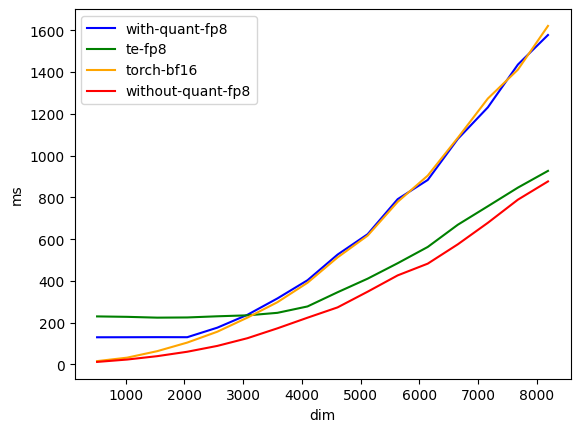

fp8:
       dim  with-quant-fp8      te-fp8   torch-bf16  without-quant-fp8
0    512.0      130.206510  230.112270    16.051019          12.200175
1   1024.0      130.428448  228.037849    32.627385          23.616003
2   1536.0      130.785748  224.168032    63.660324          39.754029
3   2048.0      130.553246  225.071758   104.807831          60.940940
4   2560.0      176.199347  230.645373   156.819329          88.898420
5   3072.0      237.708986  235.191122   224.237636         125.718772
6   3584.0      316.220015  247.239068   298.119694         173.072472
7   4096.0      403.212637  277.791589   391.188204         223.910049
8   4608.0      525.971770  345.744967   512.444377         273.262143
9   5120.0      623.636246  410.754889   616.778016         348.405868
10  5632.0      791.490793  484.761506   778.581083         426.526099
11  6144.0      883.410752  562.595665   904.311597         482.725561
12  6656.0     1079.687834  668.924630  1084.922433         575.216174
1

In [5]:
torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['dim'],  # argument names to use as an x-axis for the plot
        x_vals=[256 * i for i in range(2, 32+2, 2)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['with-quant-fp8', 'te-fp8', 'torch', 'without-quant-fp8'],  # possible values for `line_arg``
        line_names=[
            "with-quant-fp8",
            "te-fp8",
            'torch-bf16',
            'without-quant-fp8'
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-'), ('orange', '-'), ('red', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="fp8",  # name for the plot. Used also as a file name for saving the plot.
        args={'bs': 4, 'seq_len': 2048}
    ))
def benchmark(bs, seq_len, dim, provider):
    device = torch.device('cuda')
    dtype = torch.bfloat16
    device = 'cuda'
    x = torch.randn(bs, seq_len, dim).to(device).to(dtype)
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    if provider == 'with-quant-fp8':
        fc = Fp8Linear(dim, dim, bias=False).to(dtype).to(device)
        ms = triton.testing.do_bench(lambda: fc(x))

    if provider == 'without-quant-fp8':
        fc = Fp8Linear(dim, dim, bias=False).to(dtype).to(device)
        a = x.view(-1, x.size(-1)).to(torch.float8_e5m2)
        b = fc.weight.to(torch.float8_e5m2)
        ms = triton.testing.do_bench(lambda: fp8_matmul_wo_quant(a,b))

    if provider == 'te-fp8':
        if HAVE_TE:
            fc = te.Linear(dim, dim, bias=False).to(dtype).to(device)
            # Create an FP8 recipe. Note: All input args are optional.
            fp8_recipe = recipe.DelayedScaling(margin=0, fp8_format=recipe.Format.E4M3)
            def func():
                with te.fp8_autocast(enabled=True, fp8_recipe=fp8_recipe):
                    out = fc(x)
                return out
            ms = triton.testing.do_bench(lambda: func())
        else:
            ms = 100
            
    if provider == 'torch':
        fc = torch.nn.Linear(dim, dim, bias=False).to(dtype).to(device)
        ms = triton.testing.do_bench(lambda: fc(x))

    return ms * 1e3
benchmark.run(show_plots=True, print_data=True)


## backward
- 去除无量化的和te-fp8（没法单拿出来进行backward）

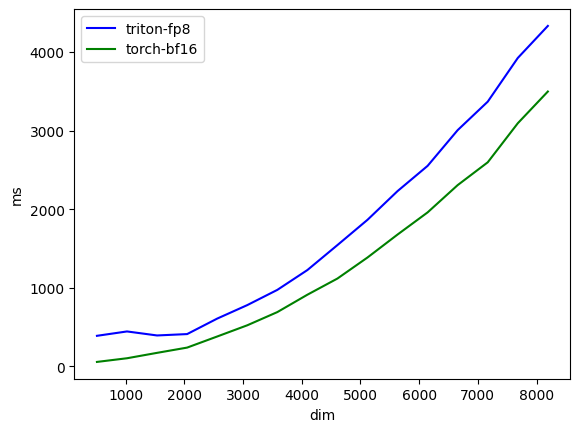

fp8:
       dim   triton-fp8   torch-bf16
0    512.0   387.836367    55.357933
1   1024.0   443.414807   102.096044
2   1536.0   392.323613   170.854986
3   2048.0   409.856558   237.756878
4   2560.0   606.997192   379.071534
5   3072.0   778.629184   521.642268
6   3584.0   972.558975   689.696491
7   4096.0  1224.984527   911.050022
8   4608.0  1543.113828  1117.092490
9   5120.0  1864.775777  1384.978414
10  5632.0  2230.494499  1677.311420
11  6144.0  2551.821947  1959.353685
12  6656.0  3006.776810  2306.646585
13  7168.0  3369.151115  2596.934557
14  7680.0  3925.501585  3094.293594
15  8192.0  4333.503723  3498.168468


In [10]:
torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['dim'],  # argument names to use as an x-axis for the plot
        x_vals=[256 * i for i in range(2, 32+2, 2)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['triton-fp8',  'torch'],  # possible values for `line_arg``
        line_names=[
            "triton-fp8",
            'torch-bf16',
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="fp8",  # name for the plot. Used also as a file name for saving the plot.
        args={'bs': 4, 'seq_len': 2048}
    ))
def benchmark(bs, seq_len, dim, provider):
    device = torch.device('cuda')
    dtype = torch.bfloat16
    device = 'cuda'
    x = torch.randn(bs, seq_len, dim).to(device).to(dtype)
    x.requires_grad_(True)
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    if provider == 'triton-fp8':
        fc = Fp8Linear(dim, dim, bias=False).to(dtype).to(device)
        y = fc(x)
        dy = torch.randn_like(y)
        ms = triton.testing.do_bench(lambda: y.backward(dy, retain_graph=True))

    # if provider == 'te-fp8':
    #     fc = te.Linear(dim, dim, bias=False).to(dtype).to(device)
    #     # Create an FP8 recipe. Note: All input args are optional.
    #     fp8_recipe = recipe.DelayedScaling(margin=0, fp8_format=recipe.Format.E4M3)
    #     with te.fp8_autocast(enabled=True, fp8_recipe=fp8_recipe):
    #         y = fc(x)
    #     loss = y.sum()
    #     loss.backward()
    #     def func():
    #         with te.fp8_autocast(enabled=True, fp8_recipe=fp8_recipe):
    #             loss.backward(retain_graph=True)
    #     ms = triton.testing.do_bench(lambda: func())
        
    if provider == 'torch':
        fc = torch.nn.Linear(dim, dim, bias=False).to(dtype).to(device)
        y = fc(x)
        dy = torch.randn_like(y)
        ms = triton.testing.do_bench(lambda: y.backward(dy, retain_graph=True))

    return ms * 1e3
benchmark.run(show_plots=True, print_data=True)
# 其实两者(offical vs my)性能差异不大, 如果想快速实现，表示清楚，直接按顺序计算即可
# dim变大之后，貌似还是torch内置的矩阵乘法更优秀
